Ideas for performance improvement:
- Static Tipying: NO!
- Numba: NoPyton, Parallelize, TypeSpecification, Nogil?
- For Random Numbers two function (Cuda vs NoCuda)

# PRODUCTION READY FUNCTION => Simulator_noGPU

In [210]:
# Load the minimum required library to run the functions
from numba import jit
from numpy import zeros, arange, uint8, int32, float32, sqrt, uint32
from numpy.random import randn
from timeit import timeit
import time
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda

from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32, xoroshiro128p_normal_float32

In [211]:
@jit(nopython = True)
def Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta, i_state = None):
    time_steps_amount = uint32(TotalT/dt) # Number of steps
    sampled_point_amount = uint32(TotalT/DeltaT) # Number of sampled points
    sampling_delta_time_steps = uint32(DeltaT/dt) # Number of steps between samples
    
    # Unpack Parameters

    mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y = theta
    
    # Handle initial state
    if i_state is None:
        x = zeros((n_sim,1), dtype = float32)
        y = zeros((n_sim,1), dtype = float32)
        f = zeros((n_sim,1), dtype = float32)
    else:
        if x.shape == (n_sim,1) or y.shape == (n_sim,1) or f.shape == (n_sim,1):
            raise Exception("Initial state has wrong shape, each should be (n_sim,1)")
        x, y, f = i_state
    
    # Initialize x_trace array
    
    x_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    
    sampling_counter = uint8(1)
    # POSSIBLE OPTIM: You could overwrite the last used row of the trace to save memory and not create a proxy array
    
    # TRADEOFF: Memory vs Speed. We can generate the numbers here, or before. Maybe the time is the same... Should test
    
    # CHECK: Benchmark the version with the explicit dx, dy, df and the one with the x, y, f arrays with the calculation in the assigment
    
    for t in arange(time_steps_amount - 1):
        x[:,] = x[:,] + mu_x*(-k_x*x[:,] + k_int*y[:,])*dt                +          sqrt(2*mu_x*D_x*dt)     *randn(n_sim,1)
        y[:,] = y[:,] + mu_y*(-k_y*y[:,] + k_int*x[:,] + f[:,])*dt        +          sqrt(2*mu_y*D_y*dt)     *randn(n_sim,1)
        f[:,] = f[:,] + -(f[:,]/tau)*dt                                   +          sqrt(2*eps**2*dt/tau)   *randn(n_sim,1)

        sampling_counter = sampling_counter + 1
        if sampling_counter == sampling_delta_time_steps:
            x_trace[:, int(t/sampling_delta_time_steps)] = x[:,0]
            sampling_counter = uint8(1)
    
    return x_trace, (x, y, f)

In [212]:
@cuda.jit(nopython = True)
def Simulator_GPU(dt, DeltaT, TotalT, n_sim, theta, rng_states, i_state = None):
    thread_id = cuda.grid(1)
    time_steps_amount = uint32(TotalT/dt) # Number of steps
    sampled_point_amount = uint32(TotalT/DeltaT) # Number of sampled points
    sampling_delta_time_steps = uint32(DeltaT/dt) # Number of steps between samples
    
    # Unpack Parameters

    mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y = theta
    
    # Handle initial state
    if i_state is None:
        x = zeros((n_sim,1), dtype = float32)
        y = zeros((n_sim,1), dtype = float32)
        f = zeros((n_sim,1), dtype = float32)
    else:
        if x.shape == (n_sim,1) or y.shape == (n_sim,1) or f.shape == (n_sim,1):
            raise Exception("Initial state has wrong shape, each should be (n_sim,1)")
        x, y, f = i_state
    
    # Initialize x_trace array
    x_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    
    sampling_counter = uint8(1)
    # POSSIBLE OPTIM: You could overwrite the last used row of the trace to save memory and not create a proxy array
    
    # TRADEOFF: Memory vs Speed. We can generate the numbers here, or before. Maybe the time is the same... Should test
    
    # CHECK: Benchmark the version with the explicit dx, dy, df and the one with the x, y, f arrays with the calculation in the assigment
    
    
    for t in arange(time_steps_amount - 1):
        for i in range(n_sim):
            x[i,] = x[i,] + mu_x*(-k_x*x[i,] + k_int*y[i,])*dt                +          sqrt(2*mu_x*D_x*dt)     *xoroshiro128p_normal_float32(rng_states, thread_id)
            y[i,] = y[i,] + mu_y*(-k_y*y[i,] + k_int*x[i,] + f[:,])*dt        +          sqrt(2*mu_y*D_y*dt)     *xoroshiro128p_normal_float32(rng_states, thread_id)
            f[i,] = f[i,] + -(f[i,]/tau)*dt                                   +          sqrt(2*eps**2*dt/tau)   *xoroshiro128p_normal_float32(rng_states, thread_id)
        sampling_counter = sampling_counter + 1
        if sampling_counter == sampling_delta_time_steps:
            x_trace[:, int(t/sampling_delta_time_steps)] = x[:,0]
            sampling_counter = uint8(1)
    
    
    return x_trace, (x, y, f)

In [213]:
@jit(nopython = True)
def Simulator_noGPU_preallocating(dt, DeltaT, TotalT, n_sim, theta, x_trace, i_state = None):
    time_steps_amount = uint32(TotalT/dt) # Number of steps
    sampled_point_amount = uint32(TotalT/DeltaT) # Number of sampled points
    sampling_delta_time_steps = uint32(DeltaT/dt) # Number of steps between samples
    
    # Unpack Parameters

    mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y = theta
    
    # Handle initial state
    if i_state is None:
        x = zeros((n_sim,1), dtype = float32)
        y = zeros((n_sim,1), dtype = float32)
        f = zeros((n_sim,1), dtype = float32)
    else:
        if x.shape == (n_sim,1) or y.shape == (n_sim,1) or f.shape == (n_sim,1):
            raise Exception("Initial state has wrong shape, each should be (n_sim,1)")
        x, y, f = i_state
    
    # Initialize x_trace array
    if x_trace is None:
        x_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    else:
        if x_trace.shape != (n_sim, sampled_point_amount):
            raise Exception("x_trace has wrong shape, should be (n_sim, sampled_point_amount)")
    
    sampling_counter = uint8(1)
    # POSSIBLE OPTIM: You could overwrite the last used row of the trace to save memory and not create a proxy array
    
    # TRADEOFF: Memory vs Speed. We can generate the numbers here, or before. Maybe the time is the same... Should test
    
    # CHECK: Benchmark the version with the explicit dx, dy, df and the one with the x, y, f arrays with the calculation in the assigment
    
    for t in arange(time_steps_amount - 1):
        x[:,] = x[:,] + mu_x*(-k_x*x[:,] + k_int*y[:,])*dt                +          sqrt(2*mu_x*D_x*dt)     *randn(n_sim,1)
        y[:,] = y[:,] + mu_y*(-k_y*y[:,] + k_int*x[:,] + f[:,])*dt        +          sqrt(2*mu_y*D_y*dt)     *randn(n_sim,1)
        f[:,] = f[:,] + -(f[:,]/tau)*dt                                   +          sqrt(2*eps**2*dt/tau)   *randn(n_sim,1)

        sampling_counter = sampling_counter + 1
        if sampling_counter == sampling_delta_time_steps:
            x_trace[:, int(t/sampling_delta_time_steps)] = x[:,0]
            sampling_counter = uint8(1)

    return (x, y, f)

In [214]:
dt = 1
DeltaT = 1
TotalT = 1000
n_sim = 1000
theta = [1, 1, 1, 1, 1, 1, 1, 1, 1]
x_trace = zeros((n_sim, uint32(TotalT/DeltaT)), dtype = float32)

In [215]:
%%time
x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 511 ms, sys: 12 ms, total: 523 ms
Wall time: 524 ms


In [216]:
%%time
state = Simulator_noGPU_preallocating(dt, DeltaT, TotalT, n_sim, theta, x_trace)

CPU times: user 669 ms, sys: 12.5 ms, total: 682 ms
Wall time: 684 ms


# Preallocating The Output seems unnecessary !

In [220]:
%%time
threads_per_block = 64
blocks = 24
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
x_trace, state = Simulator_GPU[blocks, threads_per_block](dt, DeltaT, TotalT, n_sim, theta, rng_states)
# THIS IS FOR THE CUDA GPU

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

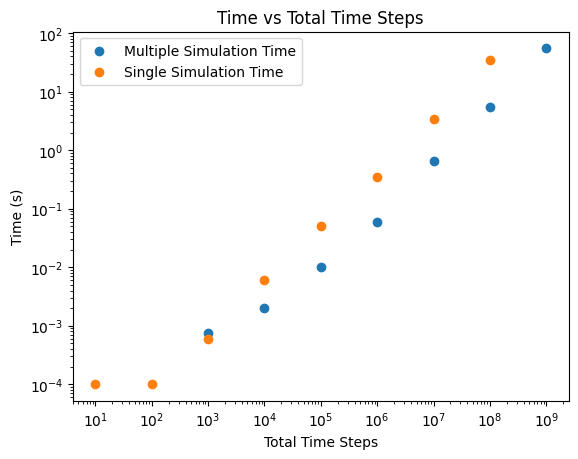

In [221]:
times_n_sim = np.array([750e-6,2e-3,10e-3,60e-3,650e-3,5.5,55])
total_time_steps_n_sims = np.array([1,10,100,1000,10000,100000,1000000])*1000
times_single_sim = np.array([100e-6,100e-6,600e-6,6e-3,50e-3,350e-3,3.4,35])
total_time_steps_single_sim = np.array([10,100,1000,10000,100000,1000000,10000000,100000000])


plt.scatter(total_time_steps_n_sims, times_n_sim, label = 'Multiple Simulation Time')
plt.scatter(total_time_steps_single_sim, times_single_sim, label = 'Single Simulation Time')
plt.xscale('log')
plt.yscale('log')
plt.title('Time vs Total Time Steps')
plt.xlabel('Total Time Steps')
plt.ylabel('Time (s)')
plt.legend();